In [1]:
initial_path = 'peptide-QML'
# initial_path = '..'

In [2]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import pytorch_model as m
from my_code import quantum_nodes as q

In [3]:
# name of the notebook
name_notebook = "sweep_4h_er_Xqm"

In [4]:
sweep = c.Sweep(
    name_notebook, 
    initial_path=initial_path,
    description="4aa Try to find the best measurement and number of layers for the quantum block using Angle Encoding (repeating embedding with different inputs) and embedding.",
    repetitions=list(range(1, 4)),
    quantum_n_layers=[1,3,5,10,20],
    quantum_measurement=[0,1,'all'],
    embedding_dim=[1,2,3,4,5,6],
)

In [5]:
sweep.save()

In [6]:
sweep = c.Sweep.load(file_name=name_notebook+"-1", day='0921', initial_path=initial_path)



 --- SWEEP POINT 5/8: (2, 1) ---
 --- time reamining: 65:13:39.60 

Epoch [0/2], Loss epoch: 0.0209, Loss validation: 0.0209
	 Validation string, 	 i: 265; 	 prediction: -0.4646, 	 target: -0.3395, 	 loss: 0.0156
	 Validation string, 	 i: 1825; 	 prediction: -0.2824, 	 target: -0.1932, 	 loss: 0.0080
	 Validation string, 	 i: 3572; 	 prediction: -0.1564, 	 target: -0.1530, 	 loss: 0.0000
Epoch [1/2], Loss epoch: 0.0083, Loss validation: 0.0083, Time remaining: ~0.0h 33.0m 4s
	 Validation string, 	 i: 1559; 	 prediction: -0.1558, 	 target: -0.1380, 	 loss: 0.0003
	 Validation string, 	 i: 528; 	 prediction: -0.2365, 	 target: -0.1202, 	 loss: 0.0135
	 Validation string, 	 i: 1865; 	 prediction: -0.2791, 	 target: -0.3791, 	 loss: 0.0100
Epoch [2/2], Loss epoch: 0.0078, Loss validation: 0.0080, Time remaining: ~0.0h 0.0m 0s


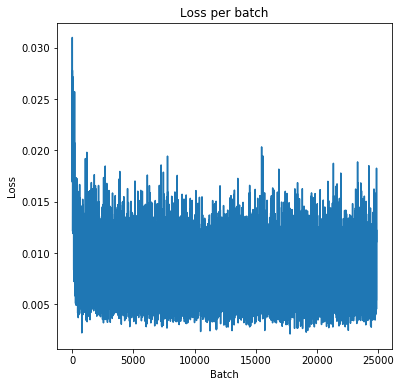

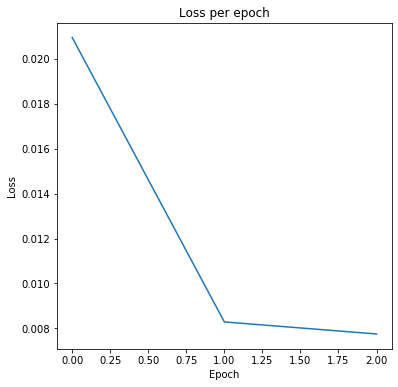

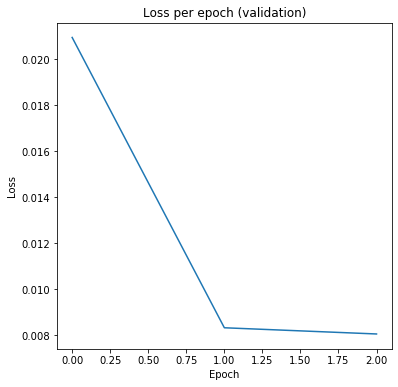

In [7]:
for sweep_point in sweep.points_left:

    # print the point of the sweep
    sweep.print_sweep_status(sweep_point['idx'])

    # -- QUANTUM BLOCK -- #
    n_qubits = 4
    quantum_layer = q.circuit(
        n_qubits = n_qubits, 
        device = "default.qubit.torch",
        device_options = {'shots': None},
        embedding = q.parts.AngleEmbedding, 
        embedding_ansatz = q.parts.Ansatz_11,
        block_ansatz = q.parts.Ansatz_11,
        final_ansatz = q.parts.Ansatz_11, # TODO CHECK IF THIS IS THE BEST OPTION
        measurement = q.parts.Measurement('Z', sweep_point['quantum_measurement']),
        embedding_n_layers = sweep_point['embedding_dim']-1,
        different_inputs_per_layer = sweep_point['embedding_dim']>1, # because when embedding_dim=1, there is only one input, and we need at least 2 to have different inputs per layer
        block_n_layers = 10,
        # wrapper_qlayer = pw.QLayerEmpty,
    )

    # -- MODEL -- #                    
    class Model(m.Model):
        def __init__(self):
            super(Model, self).__init__()
            self.fc1 = m.nn.Embedding(num_embeddings=19, embedding_dim=sweep_point['embedding_dim'])
            self.fc2 = m.Reshape()
            self.fc3 = quantum_layer()     
            if sweep_point['quantum_measurement'] == 'all':     
                self.fc4 = m.nn.Linear(n_qubits, 1)
            else:
                self.fc4 = m.nn.Linear(1, 1)

        def forward(self, x):
            for i in range(1,5):
                x = getattr(self, 'fc{}'.format(i))(x)
            return x

    model = Model()

    # set quantum layer
    model.set_quantum_layer(quantum_layer)

    # set the name and path of the model
    model.set_name_and_path(name_notebook, initial_path)

    #set sweep point
    model.set_sweep_point(
        sweep_uuid = sweep.uuid,
        sweep_point = sweep_point,
        day=sweep.day
    )

    # -- TRAIN -- #
    model.optimize_params(
        #save info
        save_model_info = True,
        description = 'sweep with 4 amino acids and 4 qubits using Angle Encoding (repeating embedding) and classical Embedding',    
        #data
        data=c.Data.load(initial_path=initial_path, file_name='PE_SCORES_4_Numbers'),
        # train options
        optimizer = m.optim.Adam,
        optimizer_options = {'lr': 0.01},
        num_epochs = 5,                
        batch_size = 32,
        # early stopping options
        stop_training_options = {
            'lookback_epochs': 3, 
            'threshold_slope': 0.001,
            'threshold_std_dev': 0.2
        },
        # metadata
        metadata = {}
    )

    # -- VALIDATION and PLOTS -- #
    model.plot_losses(fig_size=(6,6))
    model.validate(
        pct=1,
        add_to_results=True,
        plot=True,
        print_items=False
    )

    # -- SAVE RESULTS -- #
    model.save_results()

    # -- ADD DATA GENERATED TO SWEEP -- #
    sweep.add_data(
        idx=sweep_point['idx'],
        model_uuid=model.uuid,
        best_loss_train=model.results.loss_epoch.best,
        best_loss_test=model.results.loss_validation_epoch.best,
        loss_validation=model.mean_loss_validation,
        n_parameters=model.n_parameters,
        time_train=model.results.time_epoch.last,
    )
    sweep.save(csv=False) #TODO: save csv=False automatically when sweep is already saved ion csv

    